# ***Definiendo el ambiente, el agente y el learner***


## Ambiente

In [69]:
def get_area(current_state):
    actx=current_state[1]
    acty=current_state[0]
    left= actx-1
    right = actx+1
    down=acty+1
    up= acty-1
    return actx,acty,left,right,down,up

In [70]:
class Cell:
  def __init__(self,value,is_terminal,walls=[]):
    self.value=value
    self.is_terminal=is_terminal
    self.walls=walls
  
  def get_value(self):
    return self.value

  def set_value(self,value):
    self.value=value
  
  

In [71]:
import copy
import random
class Environment:
  def __init__(self, board, dimensions,actions,reward_function):
    self.board=board
    self.dimensions=dimensions
    self.is_terminal=False
    self.actions=actions
    self.reward_function = reward_function
    self.reset()

  def get_dimensions(self):
    return self.dimensions
  
  def get_current_state(self):
    return self.current_state 

  def do_action(self,action):
    return self.do_action_final_action(action)

  def do_action_final_action(self,action):
    reward,self.current_state, self.is_terminal = self.reward_function(self.current_state, action, self.board, self.dimensions)
    return [reward,self.current_state]

  def reset(self):
    self.is_terminal=False
    y=random.randrange(self.dimensions[0])
    x=random.randrange(self.dimensions[1])
    while self.board[y][x] == '*':
      y=random.randrange(self.dimensions[0])
      x=random.randrange(self.dimensions[1])
    self.current_state=[y,x]

  def set_state(self,new_state):
    self.current_state=new_state

  def is_terminal(self):
    return self.board[self.current_state[0]][self.current_state[1]].is_terminal

  def is_state_terminal(self,current_state):
    return self.board[current_state[0]][current_state[1]].is_terminal

  def get_board(self):
    return self.board

  def is_valid(self):
    return self.board[self.current_state[0]][self.current_state[1]].get_value()!='*'
  
  def is_state_valid(self,current_state):
    return self.board[current_state[0]][current_state[1]].get_value()!='*'

## Learner

In [72]:
import numpy as np
import random
class Learner:
    def __init__(self, agent, env, qtable,prev_qtable, check_convergence, alpha=0.1, gamma=0.6, epsilon=0.1,episode_cap=100000):
        #hyper parameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.environment = env
        self.agent = agent          #actual agent
        self.qtable = qtable #rewards table
        self.prev_qtable = prev_qtable
        self.check_convergence=check_convergence
        self.episode_cap = episode_cap
    
    def __initdic__(self):
        table = dict()
        for i in range(0, self.environment.end()):
            table[i] = np.zeros(len(self.agent.actions))
        return table

    def run_til_convergence(self):
      converged = False
      episodes=1
      while not converged:
        print(f'Episodio:{episodes}')
        self.run_episode()
        converged = self.check_convergence(self.qtable, self.prev_qtable, self.environment.dimensions) or episodes>self.episode_cap
        episodes+=1
        if episodes%(self.episode_cap/10)==0:
          self.epsilon=max(self.epsilon-0.1, 0.1)
      print('Q-tabla previa')
      print(self.prev_qtable)
      print('Q-tabla final')
      print(self.qtable)
      return episodes     

    def run_episode(self):
        done = False
        steps=1
        while not done:
            #print(f'steps:{steps}')
            current_state = copy.deepcopy(self.environment.get_current_state())
            if random.uniform(0,1) < self.epsilon:
                action = self.randomAction()
            else:
                tuple_state = tuple(current_state)
                acts = self.qtable[tuple_state]
                action = max(acts, key=acts.get)
            next_state, reward = self.step(action)
            current_tuple_state = tuple(current_state)
            next_tuple_state = tuple(next_state)

            old_value = self.qtable[current_tuple_state][action]
            self.prev_qtable[current_tuple_state][action]=old_value
            acts = self.qtable[next_tuple_state]
            next_max = acts[max(acts, key=acts.get)]
            new_value = old_value + self.alpha * (reward+(self.gamma*next_max)-old_value)
            self.qtable[current_tuple_state][action] = new_value
            done = self.environment.is_terminal
            steps+=1
        self.environment.reset()

    def randomAction(self):
        return random.choice(self.agent.actions)

    def step(self, action):
        reward, next_state = self.environment.do_action(action)
        # print(f'Executed action: {self.agent.getAction(action)} at state {old_state}')
        return next_state, reward       

## Agente

In [73]:
import random
class Agent:
    def __init__(self, actions):
        self.actions = actions

# ***Definición ambientes de pruebas***

## Visualización

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
def get_action_test(action):
    if action=='left':
        return '<'
    if action=='right':
        return '>'
    if action=='up':
        return '^'
    if action=='down':
        return 'v'
    if action=='exit':
        return 'x'
    if action=='pick':
        return '#'
    if action=='drop':
        return '*'
    else:
        return 'E'

def plot(qtable,mdp):
    fig1 = plt.figure(figsize=(10, 10))
    ax1 = fig1.add_subplot(111, aspect='equal')
    grid = mdp
    
    # Lineas
    for i in range(0, len(grid)+1):
      ax1.axhline(i , linewidth=2, color="#2D2D33")
    for j in range(0, len(grid[0])+1):
      ax1.axvline(j , linewidth=2, color="#2D2D33")
    
    x = list(range(len(grid)))
    y = list(range(len(grid[0])))
    xp = list(range(len(grid)))[::-1]
    yp= list(range(len(grid[0])))[::-1]
    for i in x:
        for j in y:
            yplot = xp[i]
            xplot = j
            cell = (xplot,yplot)
            if mdp[i][j].get_value() == '*': # gris
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#6c7780"))
            elif mdp[i][j].is_terminal: # verde
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#68FF33"))
            elif mdp[i][j].get_value() <0: # rojo
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#cc0000"))
            if mdp[i][j].get_value() == 'r': # Rojo
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#cc0000"))
            if mdp[i][j].get_value() == 'g': # Verde
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#68FF33"))
            if mdp[i][j].get_value() == 'b': # Azul
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#0000ff"))
            if mdp[i][j].get_value() == 'y': # Amarillo
                ax1.add_patch(patches.Rectangle(cell, 1, 1, facecolor = "#ffff00"))

            if mdp[i][j].walls:
              if 'left' in mdp[i][j].walls:
                ax1.add_patch(patches.Rectangle((xplot,yplot), 0.1, 1, facecolor = "#6c7780"))
              if 'right' in mdp[i][j].walls:
                ax1.add_patch(patches.Rectangle((xplot+0.9,yplot), 0.1, 1, facecolor = "#6c7780"))
              if 'down' in mdp[i][j].walls:
                ax1.add_patch(patches.Rectangle((xplot,yplot), 1, 0.1, facecolor = "#6c7780"))
              if 'up' in mdp[i][j].walls:
                ax1.add_patch(patches.Rectangle((xplot,yplot+0.9), 1, 0.1, facecolor = "#6c7780"))
    for i in x: 
        for j in y:
            yplot = xp[i]
            xplot = j
            if mdp[i][j].get_value() == '*':
                ax1.text(xplot+0.5, yplot+0.5, "*", ha='center', va='center')
            else:
                acts = qtable[(i,j)]
                action = max(acts, key=acts.get)
                max_val=qtable[(i,j)][action]
                text= 'None' if max_val is None else round(max_val, 2)
                text2=get_action_test(action)
                ax1.text(xplot+0.5, yplot+0.75, text, ha='center', va='center')
                ax1.text(xplot+0.5, yplot+0.25, text2, ha='center', va='center')
    
    
    plt.axis("off")
    plt.show()

## Convergencia para gridworld y laberinto

In [75]:
def check_policy_convergence(act,prev,dimensions):
  converged = True
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      tuple_state = (i,j)
      act_acts = act[tuple_state]
      # print('acts_acts:')
      # print(act_acts)
      prev_acts = prev[tuple_state]
      # print('prev_acts:')
      # print(prev_acts)
      act_action = max(act_acts, key=act_acts.get)
      prev_action = max(prev_acts, key=prev_acts.get)
      if not act_action==prev_action:
        converged=False
        break
    if not converged:
      break
  return converged

def check_values_convergence(act,prev,dimensions):
  # print('check convergence')
  converged = True
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      tuple_state = (i,j)
      act_vals = list(act[tuple_state].values())
      # print('acts_vals:')
      # print(act_vals)
      prev_vals = list(prev[tuple_state].values())
      # print('prev_vals:')
      # print(prev_vals)
      for k in range(len(act_vals)):
        act_val = act_vals[k]
        prev_val = prev_vals[k]
        diff = abs(act_val-prev_val)
        if diff>0.1:
          converged=False
          break
      if not converged:
        break  
    if not converged:
      break
  return converged

## Creación de la Q-tabla

In [76]:
def create_qtable(np_form,acts):
  acts_dict=dict.fromkeys(acts,0)
  prev_dict=dict.fromkeys(acts,-np.inf)
  list_form = np_form.tolist()
  prev = copy.deepcopy(list_form)
  for i in range(len(list_form)):
    for j in range(len(list_form[0])):
      list_form[i][j]=copy.deepcopy(acts_dict)
      prev[i][j]=copy.deepcopy(prev_dict)
  act = np.array(list_form)
  prev = np.array(prev)
  return act,prev

## Gridworld

In [77]:
import copy
a=Cell('*',False)
x=Cell(0,False)
y1=Cell(1,True)
yn100=Cell(-100,True)
y100=Cell(100,True)
yn1=Cell(-1,True)
gridworld_board=[
    [x,x,x,x,x,x,x,x,x,x],
    [x,x,x,x,x,x,x,x,x,x],
    [x,a,a,a,a,x,a,a,a,x],
    [x,x,x,x,a,x,x,x,x,x],
    [x,x,x,x,a,yn1,x,x,x,x],
    [x,x,x,x,a,y1,x,x,x,x],
    [x,x,x,x,a,x,x,x,x,x],
    [x,x,x,x,a,yn1,yn1,x,x,x],
    [x,x,x,x,x,x,x,x,x,x],
    [x,x,x,x,x,x,x,x,x,x],
]
gridworld_actions=['left','right','up','down','exit']

def gridworld_reward_function(current_state, action, board, dimensions):
    # print('reward_function')
    actx,acty,left,right,down,up = get_area(current_state)
    is_terminal=False
    if action=='left' and left>=0 and board[acty][left].get_value()!='*':
        current_state[1]-=1
    elif action=='right' and right<dimensions[1] and board[acty][right].get_value()!='*':
        current_state[1]+=1
    elif action=='up' and up>=0 and board[up][actx].get_value()!='*':
        current_state[0]-=1
    elif action=='down' and down<dimensions[0] and board[down][actx].get_value()!='*':
        current_state[0]+=1
    elif action=='exit' and board[acty][actx].is_terminal:
        is_terminal=True
    reward = board[current_state[0]][current_state[1]].get_value() if action=='exit' and board[acty][actx].is_terminal else 0
    # print('end reward_function')
    return [reward,current_state,is_terminal]

## Laberinto de cuartos

In [78]:
import copy
x=Cell(0,False)
y=Cell(1,True)
wd = Cell(0,False,['down'])
wu = Cell(0,False,['up'])
wl = Cell(0,False,['left'])
wr = Cell(0,False,['right'])
wur = Cell(0,False,['up','right'])
wul = Cell(0,False,['up','left'])
wdr = Cell(0,False,['down','right'])
wdl = Cell(0,False,['down','left'])

maze_board=[
    [x,x,y,x,wr,wl,x,x,x,x],
    [x,x,x,x,wr,wl,x,x,x,x],
    [x,x,x,x,x,x,x,x,x,x],
    [x,x,x,x,wr,wl,x,x,x,x],
    [wd,wd,x,wd,wdr,wdl,wd,x,wd,wd],
    [wu,wu,x,wu,wur,wul,wu,x,wu,wu],
    [x,x,x,x,wr,wl,x,x,x,x],
    [x,x,x,x,x,x,x,x,x,x],
    [x,x,x,x,wr,wl,x,x,x,x],
    [x,x,x,x,wr,wl,x,x,x,x]
]
maze_acts_dict={
    'left':0,
    'right':0,
    'up':0,
    'down':0
}
maze_actions=['left','right','up','down']


def maze_reward_function(current_state, action, board, dimensions):
    # print('llamando maze_reward_function')
    actx,acty,left,right,down,up = get_area(current_state)
    reward = 0 
    terminal=False
    if action in board[acty][actx].walls:
      return [0,current_state,terminal]
    if action=='left' and left>=0:
        current_state[1]-=1
    elif action=='right' and right<dimensions[1]:
        current_state[1]+=1
    elif action=='up':
      if board[current_state[0]][current_state[1]].is_terminal:
        terminal=True
        reward=board[current_state[0]][current_state[1]].get_value()
      elif up>=0:
        current_state[0]-=1
    elif action=='down' and down<dimensions[0]:
        current_state[0]+=1
    # print('info')
    # print(f'Reward:{reward} Current state:{current_state} is_terminal:{terminal}')
    return [reward,current_state,terminal]

## Taxi

### Ambiente de taxi

In [79]:
import copy
import random
class TaxiEnvironment:
  def __init__(self, board, dimensions,actions,possible_stops):
    self.board=board
    self.dimensions=dimensions
    self.is_terminal=False
    self.actions=actions
    self.possible_stops=possible_stops
    self.reset()

  def get_dimensions(self):
    return self.dimensions
  
  def get_current_state(self):
    mapped = 0
    if self.current_state[2]=='r':
      mapped=1
    elif self.current_state[2]=='g':
      mapped=2
    elif self.current_state[2]=='b':
      mapped=3
    elif self.current_state[2]=='y':
      mapped=4
    resp = copy.deepcopy(self.current_state)
    resp[2]=mapped
    return resp

  def do_action(self,action):
    return self.do_action_final_action(action)

  def do_action_final_action(self,action):
    reward = self.reward_function(action)
    new_state = self.get_current_state()
    return [reward,new_state]

  def reset(self):
    self.is_terminal=False
    self.plan_trip()
    y=random.randrange(self.dimensions[0])
    x=random.randrange(self.dimensions[1])
    self.current_state=[y,x,'n']

  def plan_trip(self):
    # pos_stops = copy.deepcopy(self.possible_stops)
    # pass_location = random.randrange(len(pos_stops))
    # self.passenger_location=pos_stops.pop(pass_location)
    # destiny_location=random.randrange(len(pos_stops))
    # self.destiny=pos_stops.pop(destiny_location)
    self.passenger_location='b'
    self.destiny='r'

  def set_state(self,new_state):
    self.current_state=new_state

  def is_terminal(self):
    return self.board[self.current_state[0]][self.current_state[1]].is_terminal

  def is_state_terminal(self,current_state):
    return self.board[current_state[0]][current_state[1]].is_terminal

  def get_board(self):
    return self.board

  def is_valid(self):
    return self.board[self.current_state[0]][self.current_state[1]].get_value()!='*'
  
  def is_state_valid(self,current_state):
    return self.board[current_state[0]][current_state[1]].get_value()!='*'

  def reward_function(self, action):
    cur_stat = [self.current_state[0],self.current_state[1]]
    actx,acty,left,right,down,up = get_area(cur_stat)

    reward = 0
    # print('Celda actual:')
    # print(repr(self.board[acty][actx]))
    if action in self.board[acty][actx].walls:
      return 0
    if action=='left' and left>=0:
        self.current_state[1]-=1
    elif action=='right' and right<self.dimensions[1]:
        self.current_state[1]+=1
    elif action=='up' and up>=0:
        self.current_state[0]-=1
    elif action=='down' and down<self.dimensions[0]:
        self.current_state[0]+=1
    elif action=='pick':
      if self.board[acty][actx].get_value()==self.passenger_location:
        self.passenger_location=''
        self.current_state[2]=copy.deepcopy(self.destiny)
        reward = 1 
      else: 
        reward = -10
    elif action=='drop':
      if self.board[acty][actx].get_value()==self.current_state[2]:
        reward = 5
      else: 
        reward = -10
      self.is_terminal = True
    return reward

### Taxi

In [80]:
def create_taxi_qtable(np_form,acts,dimensions):
  acts_dict=dict.fromkeys(acts,0)
  prev_dict=dict.fromkeys(acts,-np.inf)
  list_form = np_form.tolist()
  prev = copy.deepcopy(list_form)
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      for k in range(dimensions[2]):
        list_form[i][j][k]=copy.deepcopy(acts_dict)
        prev[i][j][k]=copy.deepcopy(prev_dict)
  act = np.array(list_form)
  prev = np.array(prev)
  return act,prev

In [88]:
import copy
x=Cell(0,False)
wl = Cell(0,False,['left'])
wr = Cell(0,False,['right'])
r=Cell('r',True)
g=Cell('g',True)
b=Cell('b',True,['left'])
y=Cell('y',True,['right'])
taxi_board=[
    [r,wr,wl,x,g],
    [x,wr,wl,x,x],
    [x,x,x,x,x],
    [wr,wl,wr,wl,x],
    [y,wl,wr,b,x]
]
possible_stops = ['r','g','b','y']
taxi_dimensions=[len(taxi_board),len(taxi_board[0]),len(possible_stops)+1]
taxi_actions = ['left','right','up','down','pick','drop']


def taxi_check_policy_convergence(act,prev,dimensions):
  converged = True
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      # for z in range(dimensions[2]):
      for z in range(2):
        tuple_state = (i,j,z)
        act_acts = act[tuple_state]
        # print('acts_acts:')
        # print(act_acts)
        prev_acts = prev[tuple_state]
        # print('prev_acts:')
        # print(prev_acts)
        act_action = max(act_acts, key=act_acts.get)
        prev_action = max(prev_acts, key=prev_acts.get)
        prev_action_val = prev_acts[prev_action]
        if not act_action==prev_action or -np.inf in prev_acts.values():
          converged=False
          break
      if not converged:
        break
    if not converged:
        break
  return converged

def taxi_check_values_convergence(act,prev,dimensions):
  converged = True
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      # for z in range(dimensions[2]):
      for z in range(2):
        tuple_state = (i,j,z)
        act_vals = list(act[tuple_state].values())
        prev_vals = list(prev[tuple_state].values())
        for k in range(len(act_vals)):
          act_val = act_vals[k]
          prev_val = prev_vals[k]
          diff = abs(act_val-prev_val)
          if diff>0.1:
            converged=False
            break
          if not converged:
            break  
      if not converged:
        break
    if not converged:
        break
  return converged

# ***Pruebas***

## Gridworld

Episodio:1
Episodio:2
Episodio:3
Episodio:4
Episodio:5
Episodio:6
Episodio:7
Episodio:8
Episodio:9
Episodio:10
Episodio:11
Episodio:12
Episodio:13
Episodio:14
Episodio:15
Episodio:16
Episodio:17
Episodio:18
Episodio:19
Episodio:20
Episodio:21
Episodio:22
Episodio:23
Episodio:24
Episodio:25
Episodio:26
Episodio:27
Episodio:28
Episodio:29
Episodio:30
Episodio:31
Episodio:32
Episodio:33
Episodio:34
Episodio:35
Episodio:36
Episodio:37
Episodio:38
Episodio:39
Episodio:40
Episodio:41
Episodio:42
Episodio:43
Episodio:44
Episodio:45
Episodio:46
Episodio:47
Episodio:48
Episodio:49
Episodio:50
Episodio:51
Episodio:52
Episodio:53
Episodio:54
Episodio:55
Episodio:56
Episodio:57
Episodio:58
Episodio:59
Episodio:60
Episodio:61
Episodio:62
Episodio:63
Episodio:64
Episodio:65
Episodio:66
Episodio:67
Episodio:68
Episodio:69
Episodio:70
Episodio:71
Episodio:72
Episodio:73
Episodio:74
Episodio:75
Episodio:76
Episodio:77
Episodio:78
Episodio:79
Episodio:80
Episodio:81
Episodio:82
Episodio:83
Episodio:84
E

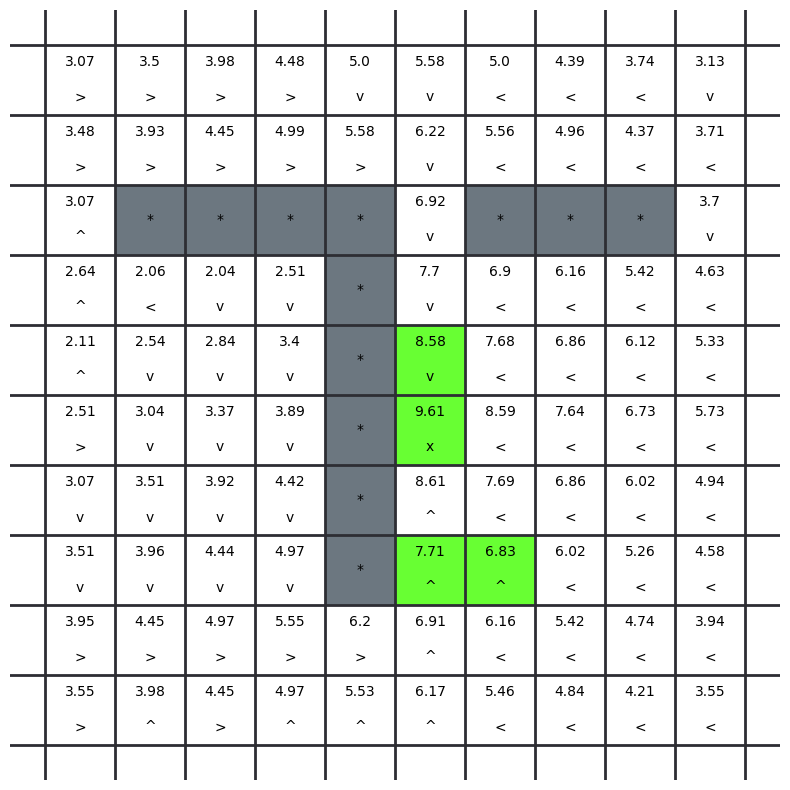

In [82]:
alpha=0.1
gamma=0.9
epsilon=0.9
board = copy.deepcopy(gridworld_board)
acts = copy.deepcopy(gridworld_actions)
dimensions=[len(board),len(board[0])]
gridworld_qtable = np.zeros((len(gridworld_board),len(gridworld_board[0])))
gridworld_qtable, gridworld_prev_qtable = create_qtable(gridworld_qtable,gridworld_actions)
# board, dimensions, initial_state,actions,reward_function
env = Environment(board,dimensions,acts,gridworld_reward_function)
agent = Agent(acts)
learn = Learner(agent,env,gridworld_qtable,gridworld_prev_qtable,check_policy_convergence,alpha,gamma,epsilon)
learn.run_til_convergence()
qtable=learn.qtable
plot(qtable,env.get_board())

## Laberinto de cuartos

Episodio:1
Episodio:2
Episodio:3
Episodio:4
Episodio:5
Episodio:6
Episodio:7
Episodio:8
Episodio:9
Episodio:10
Episodio:11
Episodio:12
Episodio:13
Episodio:14
Episodio:15
Episodio:16
Episodio:17
Episodio:18
Episodio:19
Episodio:20
Episodio:21
Episodio:22
Episodio:23
Episodio:24
Episodio:25
Episodio:26
Episodio:27
Episodio:28
Episodio:29
Episodio:30
Episodio:31
Episodio:32
Episodio:33
Episodio:34
Episodio:35
Episodio:36
Episodio:37
Episodio:38
Episodio:39
Episodio:40
Episodio:41
Episodio:42
Episodio:43
Episodio:44
Episodio:45
Episodio:46
Episodio:47
Episodio:48
Episodio:49
Episodio:50
Episodio:51
Episodio:52
Episodio:53
Episodio:54
Episodio:55
Episodio:56
Episodio:57
Episodio:58
Episodio:59
Episodio:60
Episodio:61
Episodio:62
Episodio:63
Episodio:64
Episodio:65
Episodio:66
Episodio:67
Episodio:68
Episodio:69
Episodio:70
Episodio:71
Episodio:72
Episodio:73
Episodio:74
Episodio:75
Episodio:76
Episodio:77
Episodio:78
Episodio:79
Episodio:80
Episodio:81
Episodio:82
Episodio:83
Episodio:84
E

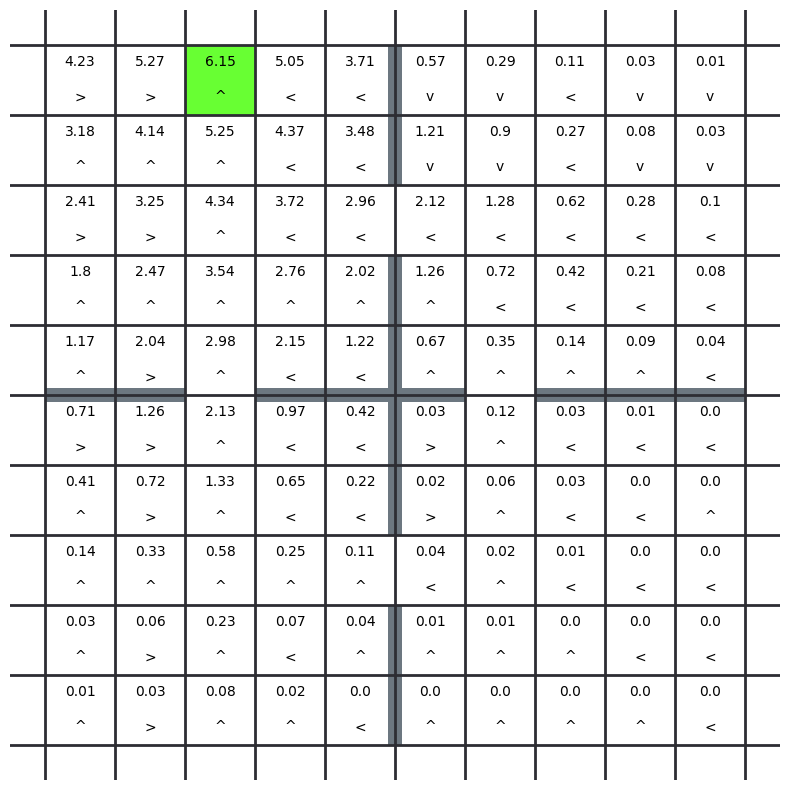

In [83]:
alpha=0.1
gamma=0.9
epsilon=0.9
board = copy.deepcopy(maze_board)
acts = copy.deepcopy(maze_actions)
dimensions=[len(board),len(board[0])]
# board, dimensions, initial_state,actions,reward_function
maze_qtable = np.zeros((len(maze_board),len(maze_board[0])))
maze_qtable, maze_prev_qtable = create_qtable(maze_qtable,maze_actions)
env = Environment(board,dimensions,acts,maze_reward_function)
agent = Agent(acts)
learn = Learner(agent,env,maze_qtable,maze_prev_qtable,check_policy_convergence,alpha,gamma,epsilon)
learn.run_til_convergence()
qtable=learn.qtable
plot(qtable,env.get_board())

## Taxi

Streaming output truncated to the last 5000 lines.
Episodio:3656
Episodio:3657
Episodio:3658
Episodio:3659
Episodio:3660
Episodio:3661
Episodio:3662
Episodio:3663
Episodio:3664
Episodio:3665
Episodio:3666
Episodio:3667
Episodio:3668
Episodio:3669
Episodio:3670
Episodio:3671
Episodio:3672
Episodio:3673
Episodio:3674
Episodio:3675
Episodio:3676
Episodio:3677
Episodio:3678
Episodio:3679
Episodio:3680
Episodio:3681
Episodio:3682
Episodio:3683
Episodio:3684
Episodio:3685
Episodio:3686
Episodio:3687
Episodio:3688
Episodio:3689
Episodio:3690
Episodio:3691
Episodio:3692
Episodio:3693
Episodio:3694
Episodio:3695
Episodio:3696
Episodio:3697
Episodio:3698
Episodio:3699
Episodio:3700
Episodio:3701
Episodio:3702
Episodio:3703
Episodio:3704
Episodio:3705
Episodio:3706
Episodio:3707
Episodio:3708
Episodio:3709
Episodio:3710
Episodio:3711
Episodio:3712
Episodio:3713
Episodio:3714
Episodio:3715
Episodio:3716
Episodio:3717
Episodio:3718
Episodio:3719
Episodio:3720
Episodio:3721
Episodio:3722
Episodio:37

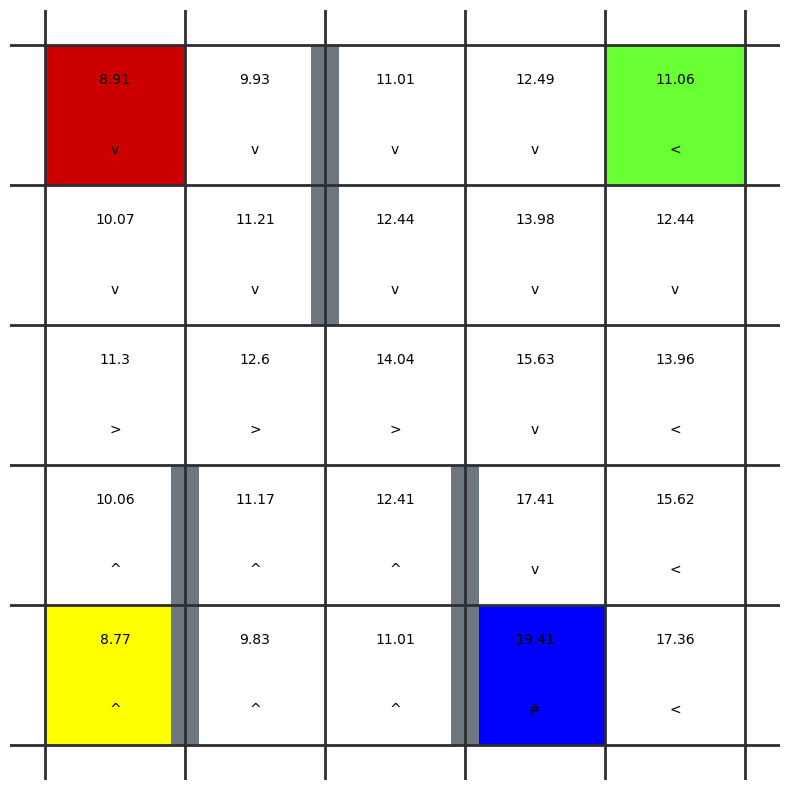

--------------------------------------------------------- Destino: r ---------------------------------------------------------


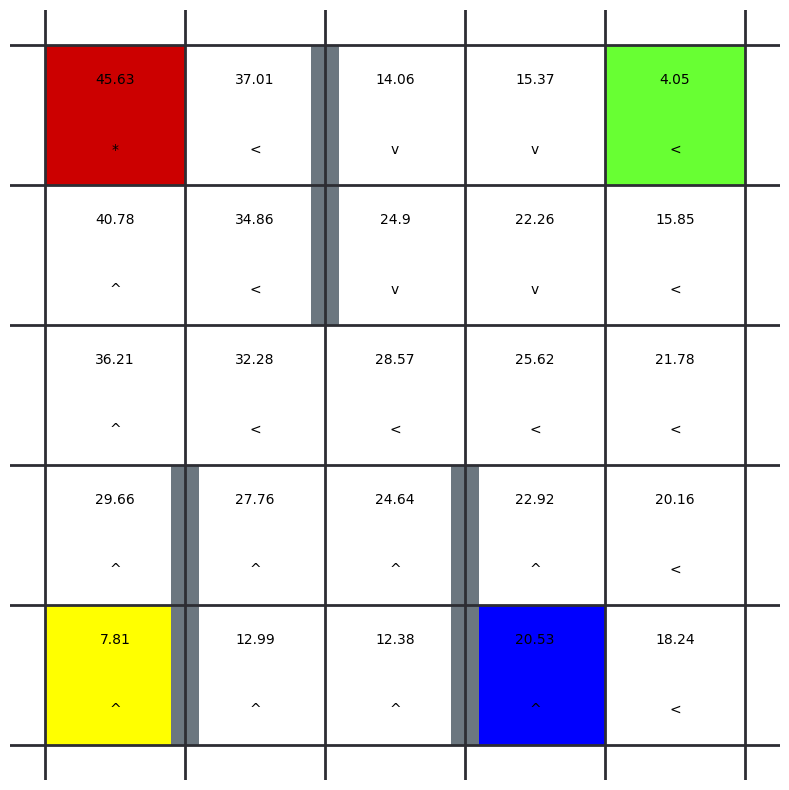

In [89]:
alpha=0.3
gamma=0.9
epsilon=0.9
board = copy.deepcopy(taxi_board)
acts = copy.deepcopy(taxi_actions)
# board, dimensions, initial_state,actions,reward_function
dimensions=[len(board),len(board[0]),len(board[1])]
taxi_qtable=np.zeros((len(taxi_board),len(taxi_board[0]),len(possible_stops)+1))
# dimensions=[len(board),len(board[0]),2]
# taxi_qtable=np.zeros((len(taxi_board),len(taxi_board[0]),2))
taxi_qtable,taxi_prev_qtable=create_taxi_qtable(taxi_qtable,taxi_actions,taxi_dimensions)
env = TaxiEnvironment(board,dimensions,acts,possible_stops)
agent = Agent(acts)
learn = Learner(agent,env,taxi_qtable,taxi_prev_qtable,taxi_check_policy_convergence,alpha,gamma,epsilon,25000)
learn.run_til_convergence()
qtable=learn.qtable
print('--------------------------------------------------------- Sin pasajero (siempre se encuentra en b) ---------------------------------------------------------')
plot(qtable[:,:,0],env.get_board())
print('--------------------------------------------------------- Destino: r ---------------------------------------------------------')
plot(qtable[:,:,1],env.get_board())
# print('------------------------- Destino: g ------------------')
# plot(qtable[:,:,2],env.get_board())
# print('------------------------- Destino: b ------------------')
# plot(qtable[:,:,3],env.get_board())
# print('------------------------- Destino: y ------------------')
# plot(qtable[:,:,4],env.get_board())

# Análisis 

Se evidencia que Q-learning es un muy buen algoritmo de reinforcement learning, ya que corre relativamente rapido y alcanza muy buenos resultados como se pudo observar en los 3 previos casos. Cabe recalcar también que en los primeros dos la politica convergió rápidamente lo que tiene sentido ya que son ejemplos pequeños y de baja complejidad. 

Por otro lado, en el caso de taxi a pesar de que también se usó convergencia de politicas en vez de politicas, debido al complejo espacio de estados y tener una selección de politicas ϵ-greedy se decidió revisar solo sobre el caso en el que el pasajero siempre espera en la casilla azul y se dirige a la roja de forma que el algoritmo convergiera rapidamente, por lo que la función de convergencia de politicas fue modificada para no revisar toda la q-tabla sino solo ese espacio de estados reducido. De igual forma se aplicó una reducción de ϵ conforme pasaban las iteraciones de forma que se logrará mantener mayor tiempo en el espacio de estado en el cual el pasajero está en el taxi (y que tuviera menos probabilidad de dejarlo donde no es) para que aprendiera mejor durante este espacio de tiempo.

Por otro lado, se evidencia que para estos casos de 'busqueda de caminos' es mejor tener un factor de descuento (γ) cercano a uno, de forma que se busque la mejor recompensa a largo plazo y por ende el camino más corto a la meta. De igual forma, al ser ambientes deterministicos, una tasa de aprendizaje (α) cercana a 0 (como 0.1) es ideal ya que se le da más importancia a las observaciones pasadas y cómo el ambiente es deterministico se espera que los valores futuros sean muy similares a los actuales por lo que no van a traer información nueva muy relevante, debido a esto una tasa de aprendizaje baja permite llegar a la politica deseada de forma más rápida debido a que los nuevos valores no afectan mucho lo aprendido previamente. Finalmente se observa que para los primeros dos casos donde el espacio de estados no es muy complejo, un ϵ=0.9 permite de igual forma una rápida convergencia del algoritmo al revisar más rápidamente todas las acciones para todos los estados, sin embargo para el caso del taxi es bueno aplicarle decaimiento al ϵ de forma que al principio busque mucho pero cuando ya tenga al pasajero procure llevarlo a su destino y aprender dichos caminos de mejor forma en vez de arriesgarse a dejarlo donde no debe. 